# Simulated examples for bias detection

In [2]:
import sys
sys.path.append('..')
import random
from bias_detection.bias_tree import BiasDetectionTree
from bias_detection.metric import get_metric_bias_tree_for_model, absolute, value, underestimation, overestimation
from data_preparation.simulated_movies import SimulatedMovieData, SimulatedGenericData
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import levene
from itertools import combinations

## Analyze bias for synthetic examples

### Prepare synthetic dataset 

In [2]:
data = SimulatedMovieData(data_path='../data/',n_bins=3, bucket_labels=["low", "medium", "high"], n_interactions=1000)
ratings = data.get_ratings_with_metadata()
ratings

,user,item,rating,genre,gender,age,year,age_bucketized,year_bucketized
0,189,121,3,Thriller,Male,46,2001,high,medium
1,14,146,2,Crime,Other,34,1989,medium,low
2,154,327,4,Action,Other,57,1986,high,low
3,315,279,2,Crime,Male,30,1980,low,low
4,460,101,0,Comedy,Male,19,1999,low,medium
...,...,...,...,...,...,...,...,...,...
995,136,181,4,Crime,Other,18,2017,low,high
996,298,143,2,Thriller,Other,13,1994,low,medium
997,339,180,4,Thriller,Male,72,1994,high,medium
998,5,286,4,Thriller,Female,52,2013,high,high


### Analyze bias examples

No bias

root=[]: 1.501



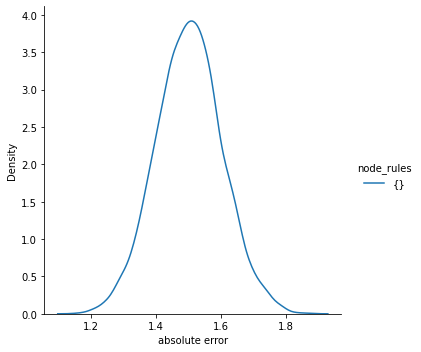

,count_val,mean_val,std_val,min_val,25%_val,50%_val,75%_val,max_val,count,mean,std,min,25%,50%,75%,max,global
node_rules,,,,,,,,,,,,,,,,,
{},7500.0,1.500838,0.101562,1.147711,1.432315,1.50093,1.56758,1.876683,2500.0,1.49965,0.099285,1.162977,1.432272,1.499706,1.564005,1.835892,1.500838


In [33]:
METRIC_NAME = 'absolute error'
metric_normal = lambda x: random.normalvariate(1.5, .1) 

ratings[METRIC_NAME] = ratings.apply(metric_normal,  1)
bias_detection_tree = BiasDetectionTree(min_child_node_size=1000, alpha=0.01, metric_col=METRIC_NAME, dataset_name="simulation")
node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict, metric_with_metadata=ratings)
node_metric

Higher underestimation error for females and thriller movies

root=[]: 0.07
├── genre=['Action', 'Crime', 'Comedy']: 0.039
└── genre=['Thriller']: 0.17
    ├── gender=['Female']: 0.497
    └── gender=['Male', 'Other']: 0.038



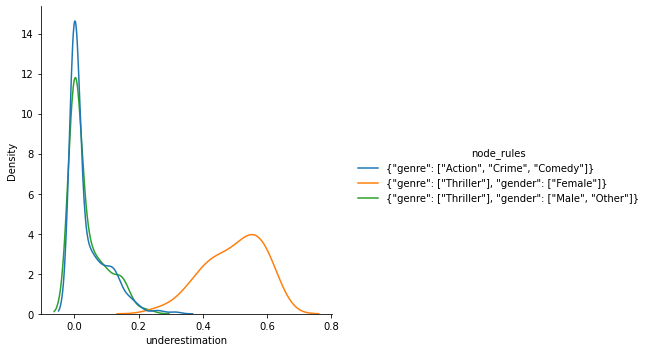

In [3]:
MIN_CHILD_NODE_SIZE = 10
METRIC_NAME = 'underestimation'
ratings_dist_female_thriller_bias = lambda x: random.normalvariate(x['rating']-.5, 0.1) if (x['genre']=="Thriller" and x['gender']=='Female') \
                                                                                else random.normalvariate(x['rating'], 0.1)
ratings['prediction'] = ratings.apply(ratings_dist_female_thriller_bias,  1)
ratings[METRIC_NAME] = underestimation(ratings['prediction'], ratings['rating'])
bias_detection_tree = BiasDetectionTree(min_child_node_size=MIN_CHILD_NODE_SIZE,
                                        alpha=0.0001, metric_col=METRIC_NAME, max_depth=2, dataset_name="simulation")
node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict,
                                               metric_with_metadata=ratings)

Higher absolute error for old crime movies

root=[]: 0.351
├── genre=['Action', 'Comedy', 'Thriller']: 0.325
│   ├── gender=['Female']: 0.3
│   └── gender=['Male', 'Other']: 0.338
└── genre=['Crime']: 0.43
    ├── year_bucketized=['high', 'medium']: 0.32
    └── year_bucketized=['low']: 0.636



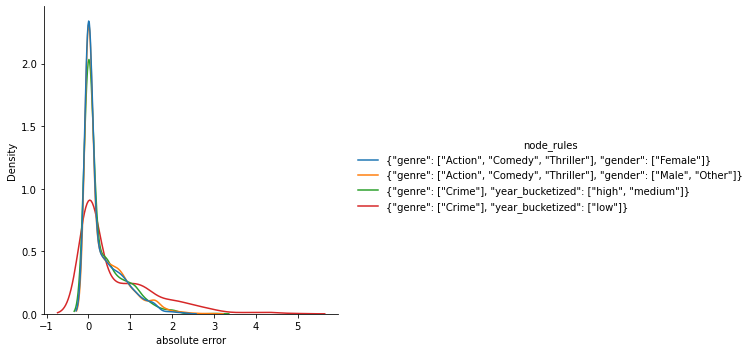

In [10]:
MIN_CHILD_NODE_SIZE = 10
METRIC_NAME = 'absolute error'
ratings_dist_old_crime = lambda x: random.normalvariate(x['rating'], 1.5) if (x['year_bucketized']=='low' and x['genre']=="Crime") \
                                                                                else random.normalvariate(x['rating'], 0.8)
ratings['prediction'] = ratings.apply(ratings_dist_old_crime,  1)
ratings[METRIC_NAME] = underestimation(ratings['prediction'], ratings['rating'])
bias_detection_tree = BiasDetectionTree(min_child_node_size=MIN_CHILD_NODE_SIZE,
                                        alpha=0.01, metric_col=METRIC_NAME, max_depth=2, dataset_name="simulation")
node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict,
                                               metric_with_metadata=ratings)

### Analyze p values 

In [15]:
bias_detection_tree.bias_tree

[([], {'mean': 0.3512592341367132, 's.t.d': 0.5310593223111599}, (genre, p=8.467532100284961e-14, score=55.90511928762767, groups=[['Action', 'Comedy', 'Thriller'], ['Crime']]), dof=7498)), (['Action', 'Comedy', 'Thriller'], {'mean': 0.32531780414294853, 's.t.d': 0.47544121136181927}, (gender, p=0.004437040170970131, score=8.102240932715192, groups=[['Female'], ['Male', 'Other']]), dof=5632)), (['Female'], {'mean': 0.29995901167546624, 's.t.d': 0.4435577820868731}, <Invalid Chaid Split> - the max depth has been reached), (['Male', 'Other'], {'mean': 0.33774569159130746, 's.t.d': 0.4898311448969698}, <Invalid Chaid Split> - the max depth has been reached), (['Crime'], {'mean': 0.42958400186708323, 's.t.d': 0.6654895540582344}, (year_bucketized, p=1.1953589181170385e-25, score=112.92367399860814, groups=[['high', 'medium'], ['low']]), dof=1864)), (['high', 'medium'], {'mean': 0.3204289628513145, 's.t.d': 0.46838264915112704}, <Invalid Chaid Split> - the max depth has been reached), (['lo

In [30]:
cols = ["genre", "gender", "age_bucketized", "year_bucketized"]
for col in cols:
    print(col)
    for c1, c2 in combinations(ratings[col].unique(), 2):
        print(c1, c2)
        stat = levene(ratings[ratings[col] == c1][METRIC_NAME], ratings[ratings[col] == c2][METRIC_NAME])
        print(stat.statistic, stat.pvalue)
        
    print( levene(*[ratings[ratings[col] == c][METRIC_NAME] for c in ratings[col].unique()]))
    print()

genre
Action Crime
0.754924010687089 0.38496240993516195
Action Thriller
3.4298919654952376 0.06408576748492344
Action Comedy
1.1876787015352952 0.2758503411122548
Crime Thriller
7.248249796053951 0.0071208962763013054
Crime Comedy
0.050505981772966745 0.8221942585513207
Thriller Comedy
8.406084971781732 0.003756386133553696
LeveneResult(statistic=3.4375226629757933, pvalue=0.016123261578904934)

gender
Female Other
0.4985082485821711 0.48018116882354345
Female Male
0.0026146300795116878 0.9592206883621305
Other Male
0.43833694266555984 0.5079493170194658
LeveneResult(statistic=0.3100233959137939, pvalue=0.7334368479471318)

age_bucketized
high medium
1.4990376409837363 0.22086340260207946
high low
0.01138765917169479 0.9150199014507291
medium low
1.794712341387195 0.18039807719555945
LeveneResult(statistic=1.1031130816878256, pvalue=0.3318768285528029)

year_bucketized
high medium
0.8882506079405531 0.34598630257505547
high low
0.015675824227369215 0.9003665714597195
medium low
0.6916

In [14]:
for col in ratings["genre"].unique():
    print(col)
    stat = levene(ratings[ratings["genre"].isin(["Action", "Thriller"])][METRIC_NAME], ratings[ratings["genre"] == col][METRIC_NAME])
    print(stat.statistic, stat.pvalue)


Comedy
0.11659061185777454 0.7327716421384982

Crime
52.15140475142567 5.643014717045283e-13

Thriller
1.2308547099666114 0.2672762316411122

Action
1.3831595424922545 0.23960129409468028



## Analyze computation time

In [93]:
import time

MIN_CHILD_NODE_SIZE = 1
METRIC_NAME = 'test'

def get_metric_dist(x, discriminated_rules, data):
    for a in data.attributes:
        if x[a] in discriminated_rules:
            return random.normalvariate(discriminated_rules[x[a]][0], discriminated_rules[x[a]][1])
        else:
            return random.normalvariate(1, 0.5)
        
def simulate_with_time(n_iter=10, n_samples_range=[10000], n_attributes_range=[5], 
                                                n_categories_per_attribute_range=[4], 
                       ratio_discriminated_cat_range=[0.5],
                      max_depth_range=[3, 20]):
    time_stats = []
    for i in range(n_iter):
        print(i)
        for n_samples in n_samples_range:
            for n_attributes in n_attributes_range:
                for n_categories_per_attribute in n_categories_per_attribute_range:
                    for ratio_discriminated_cat in ratio_discriminated_cat_range:
                        for max_depth in max_depth_range:
                            n_discriminated_cat = round(n_categories_per_attribute * ratio_discriminated_cat)
                            data = SimulatedGenericData(data_path='data/', n_interactions=n_samples, n_attributes=n_attributes,
                                                        n_categories_per_attribute=n_categories_per_attribute)
                            ratings = data.get_ratings_with_metadata()
                            rule_dist = {c: (5 * np.random.random(), 2*np.random.random())  
                                         for c in np.random.choice(data.categories, n_discriminated_cat)}
                            ratings[METRIC_NAME] = ratings.apply(lambda x: get_metric_dist(x, rule_dist, data), 1)
                            bias_detection_tree = BiasDetectionTree(min_child_node_size=MIN_CHILD_NODE_SIZE,
                                                                    alpha=0.01, metric_col=METRIC_NAME, max_depth=max_depth, 
                                                                    dataset_name="simulation")
                            start_time = time.time()
                            node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict, 
                                                                           metric_with_metadata=ratings,
                                                                           plot_bias_tree=False, 
                                                             plot_nodes_distribution=False)
                            time_stats.append({"n_samples": n_samples, "n_attributes": n_attributes, 
                                               "n_categories_per_attribute": n_categories_per_attribute,
                                               "ratio_discriminated_cat": ratio_discriminated_cat,
                                               "time[s]": time.time() - start_time,
                                              "$D$": max_depth})
    return time_stats


In [116]:
MIN_CHILD_NODE_SIZE = 1
METRIC_NAME = 'test'


        
def simulate_theoretical(n_iter=10, n_samples_range=[10000], n_attributes_range=[5], 
                                                n_categories_per_attribute_range=[4], 
                       ratio_discriminated_cat_range=[0.5],
                      max_depth_range=[3, 20]):
    time_stats = []
    for i in range(n_iter):
        for n_samples in n_samples_range:
            for n_attributes in n_attributes_range:
                for n_categories_per_attribute in n_categories_per_attribute_range:
                    for ratio_discriminated_cat in ratio_discriminated_cat_range:
                        for max_depth in max_depth_range:
#                             print(round(ratio_discriminated_cat*n_categories_per_attribute))
                            complexity = round(ratio_discriminated_cat*n_categories_per_attribute)**(min(max_depth, n_attributes) -2) \
                            * n_attributes * (n_categories_per_attribute**3) * n_samples * 1.0
                            time_stats.append({"n_samples": n_samples, "n_attributes": n_attributes, 
                                               "n_categories_per_attribute": n_categories_per_attribute,
                                               "ratio_discriminated_cat": ratio_discriminated_cat,
                                               "n operations": complexity,
                                              "$D$": max_depth})
    return time_stats


n_samples


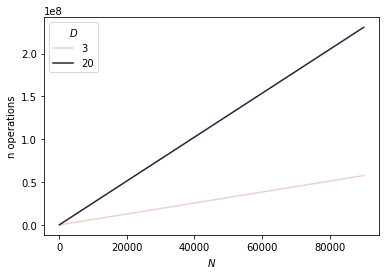

n_attributes


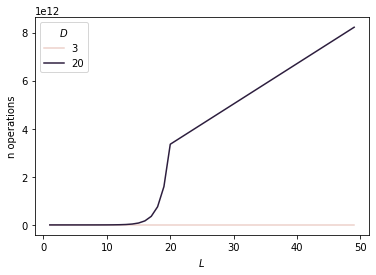

n_categories_per_attribute


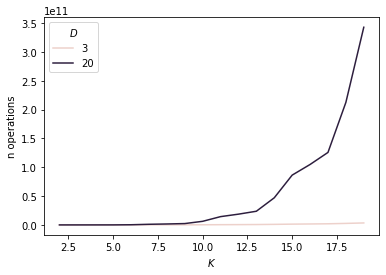

ratio_discriminated_cat


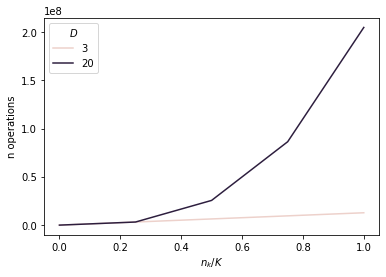

In [118]:
import numpy as np
time_test_grid = {
    "n_samples": range(100, 100000, 10000),
                 "n_attributes": range(1, 50),
                 "n_categories_per_attribute": range(2, 20),
                 "ratio_discriminated_cat": np.linspace(0,1,5)
}
param_names = {"n_samples": "$N$",
                "n_attributes": "$L$",
                "n_categories_per_attribute": "$K$",
              "ratio_discriminated_cat": "$n_k/K$"}
for param in time_test_grid:
    print(param)
    time_stats = simulate_theoretical(n_iter=10,  **{f'{param}_range': time_test_grid[param]})
    ax = sns.lineplot(data=pd.DataFrame(time_stats), x=param, y='n operations', hue="$D$", err_style="bars")
    ax.set(xlabel=param_names[param])
    ax.ticklabel_format(style='sci', axis='y')
    plt.savefig(f'time_{param}_theory.png', dpi=100)
    plt.show()

n_samples
0
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
1
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4


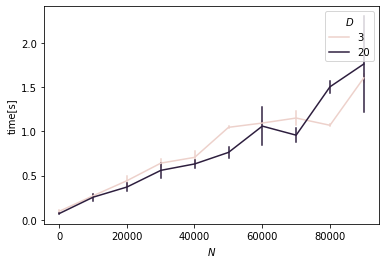

In [104]:
time_test_grid = {
    "n_samples": range(100, 100000, 10000),
                 "n_attributes": range(1, 50, 5),
                 "n_categories_per_attribute": range(2, 20, 2),
                 "ratio_discriminated_cat": np.linspace(0, 1, 5)
}
param_names = {"n_samples": "$N$",
                "n_attributes": "$L$",
                "n_categories_per_attribute": "$K$",
                "ratio_discriminated_cat": "$n_k/K$"}
for param in time_test_grid:
    print(param)
    time_stats = simulate_with_time(n_iter=2, **{f'{param}_range': time_test_grid[param]})
    ax = sns.lineplot(data=pd.DataFrame(time_stats), x=param, y='time[s]', hue="$D$", err_style="bars")
    ax.set(xlabel=param_names[param])
    plt.savefig(f'time_{param}.png', dpi=100)
    plt.show()